## Collaborative filtering using Alternating Least Squares (ALS)

In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import norm, solve
import time
import matplotlib.pyplot as plt
import math

### Download the Movielens Dataset

In [2]:
# !curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip
# !unzip ml-100k.zip # if you dont have unzip: apt-get install unzip
# !cd ml-100k/ml-100k

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4808k  100 4808k    0     0  4957k      0 --:--:-- --:--:-- --:--:-- 4952k
Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


### Create the Ratings Matrix

In [2]:
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv(r"./ml-100k/ml-100k/u.data", sep='\t', names=names)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


We see that there are 943 users and 1682 items

In [3]:
ratings_matrix = np.empty((df.user_id.nunique(), df.item_id.nunique())).astype(np.float32)
for row in df.index:
    ratings_matrix[df.iloc[row].user_id-1, df.iloc[row].item_id-1] = df.iloc[row].rating
print ('number of users = {}'.format(df.user_id.nunique()))
print ('number of items = {}'.format(df.item_id.nunique()))

number of users = 943
number of items = 1682


We see that the dataset contains many empty entries

In [5]:
zeroentries = (1-np.count_nonzero(ratings_matrix) /(ratings_matrix.shape[0]*ratings_matrix.shape[1]))*100
print ('Zero entries = {:4.2f}%'.format(zeroentries))

Zero entries = 93.70%


We see that most of the entries in the ratings matrices are zeros

### We develop a simple class for performing ALS

We minimize,
$$L = || R - U^{T} V||_{2}^{2} + \lambda_{1}||U||_{2}^{2} + \lambda_{2}||V||_{2}^{2}$$
w.r.t $U$ and $V$,

We first fix $U$ and solve for $V$ by setting $\frac{\partial L}{\partial V} = 0$, we obtain
$$V = (UU^{T} + \lambda_{1}I)^{-1}UR$$
Similarly, we obtain $U$,
$$U = (VV^T + \lambda_{2}I)^{-1}VR^T$$



In [12]:
class ALS:
    
    def __init__(self):
        """
            description: a simple class for performing
                         matrix factorization using alternating
                         least squares
                         this makes use of numpy.linalg.solve
        """
        self.n_factors = 0 # number of latent factors
        self.user_reg = 0.0 # regularization parameter for user latent matrix
        self.item_reg = 0.0 # regularization parameter for item latent matrix


    def set_factors(self, n_factors):
        """
            description: sets the number of latent factors
        """
        self.n_factors = n_factors
        return self
    
    def set_user_reg_param(self, user_reg):
        """
            description: sets the regularization parameter
                         for user latent-factor matrix
        """
        self.user_reg = user_reg
        self.user_regmat = self.user_reg*np.eye(self.n_factors)
        return self
    
    def set_item_reg_param(self, item_reg):
         """
            description: sets the regularization parameter
                         for item latent-ffactor matrix
        """
        self.item_reg = item_reg
        self.item_regmat = self.item_reg*np.eye(self.n_factors)
        return self
    
    def set_initial_factor_matrices(self, nusers, nitems):
        """
            description: sets the initial latent-factor matrices
        """
        self.U = np.random.random((self.n_factors, nusers)).astype(np.float32)
        self.V = np.random.random((self.n_factors, nitems)).astype(np.float32)
        return self
        
    def get_n_factors(self):
        """
            description: gets the number of latent factors
        """
        return self.n_factors
    
    def get_user_reg_param(self):
        """
            description: gets the regularization parameter
                         for user latent factor matrix
        """
        return self.user_reg
    
    def get_item_reg_param(self):
         """
            description: gets the regularization parameter
                         for item latent factor matrix
        """
        return self.item_reg
    
    def get_factor_matrices(self):
         """
            description: gets user and item latent
                         factor matrices
        """
        return self.U, self.V
    
    def get_loss(self, ratings):
         """
            description: gets the MSE loss
        """
        return norm(ratings - np.matmul(self.U.T, self.V) + 
               self.user_reg*norm(self.U) + self.item_reg*norm(self.V))
    
    def solve_latent_vectors(self, ratings, case):
         """
            description: performs alternating least squares 
                         matrix factorization
        """
        if(case == 'user'):    
            
            # items matrix fixed (i.e. V is fixed)
            rhs = np.matmul(self.V, ratings.T)
            self.U = solve((np.matmul(self.V, self.V.T) + self.user_regmat), rhs)

        elif(case == 'item'):
        
            # users matrix fixed (i.e. U is fixed)
            rhs = np.matmul(self.U, ratings)
            self.V = solve((np.matmul(self.U, self.U.T) + self.item_regmat), rhs)
            

In [15]:
# number of latent factors
n_factors = 40

# construct the ALS object
als = ALS().set_factors(n_factors)\
           .set_user_reg_param(0.1)\
           .set_item_reg_param(0.1)\
           .set_initial_factor_matrices(ratings_matrix.shape[0], ratings_matrix.shape[1])

#set epochs
epochs = 1000
U_norm = []
V_norm = []
L = []

# training
U, V = als.get_factor_matrices()
t0 = time.time()

for i in range(epochs):
 
    # update U
    als.solve_latent_vectors(ratings_matrix, 'user')
    
    #update V
    als.solve_latent_vectors(ratings_matrix, 'item')

    U_new, V_new = als.get_factor_matrices()
    
    # gather stats for loss
    L.append(als.get_loss(ratings_matrix))
    U_norm.append(norm((U_new - U)))
    V_norm.append(norm((V_new - V)))
    
    U, V = U_new, V_new

print("Time taken for the run = {:5.2f} s".format(time.time()-t0))

Time taken for the run = 49.22 s


### We plot the MSE loss function as well the convergence of factor matrices (U, V)

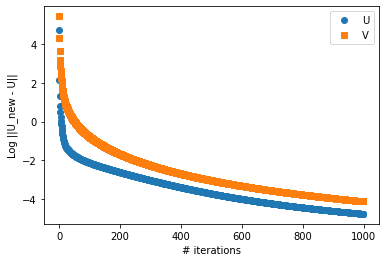

In [19]:
plt.plot(np.log(U_norm), 'o', np.log(V_norm),'s')
plt.xlabel('# iterations')
plt.ylabel('Log ||U_new - U||')
plt.legend(['U','V'])
plt.show()

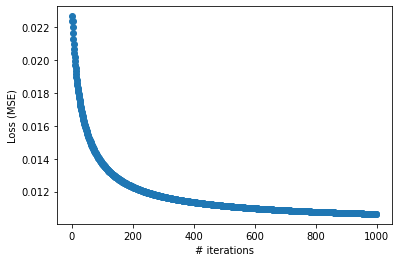

In [18]:
plt.plot(np.array(L)/(ratings_matrix.shape[0]*ratings_matrix.shape[1]), 'o')
plt.xlabel('# iterations')
plt.ylabel('Loss (MSE)')
plt.show()

## 